<h2 style="color: darkslategray">Project for "WikiShop" with BERT<a class="tocSkip"></a></h2>

The online store "WikiShop" is launching a new service. Now users can edit and enhance product descriptions, similar to wiki communities. This means that customers can suggest their edits and comment on other changes. The store needs a tool that will detect toxic comments and send them for moderation.

**Project Objective:** To train a model to classify comments as positive or negative. We have a dataset with labels indicating the toxicity of the edits.

**The goal** is to build a model with an F1 quality metric of at least 0.75.

**Project Process**

The research will be conducted in 4 stages:

- 1. Data preparation.
- 2. Model training.
- 3. Model testing.
- 4. Overall conclusion.

**Data Description**

The data is contained in the file `toxic_comments.csv`. The column *text* contains the comment text, and *toxic* represents the target feature.

The problem can be solved both with and without the use of the **BERT** neural network. We will try both approaches.

<img src="https://img.freepik.com/free-vector/customer-feedback-concept-illustration_114360-7038.jpg" width="600" height="600" alt="Bar Chart" />

## Data Preparation

Let's load the necessary libraries and open the data file.

In [1]:
# Library imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

import re
import torch
from torch.utils.data import Dataset, DataLoader
import transformers

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
%env PYTHONWARNINGS = ignore

RANDOM_STATE = 12345

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stopwords = nltk_stopwords.words('english')

env: PYTHONWARNINGS=ignore


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/igor.arkhipov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/igor.arkhipov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/igor.arkhipov/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# File import

df_comments = pd.read_csv("./toxic_comments.csv")

Now we will proceed to exploring the available data.

In [3]:
# Displaying the first 5 rows of the table

df_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Removing the redundant column that duplicates the indices.

In [4]:
# Column removal

df_comments = df_comments.drop(df_comments.columns[0], axis=1)

In [5]:
# Displaying general information about the dataframe

df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


The dataset contains 2 features and 159,292 observations. There are no missing values. Let's examine the class distribution in the target feature.

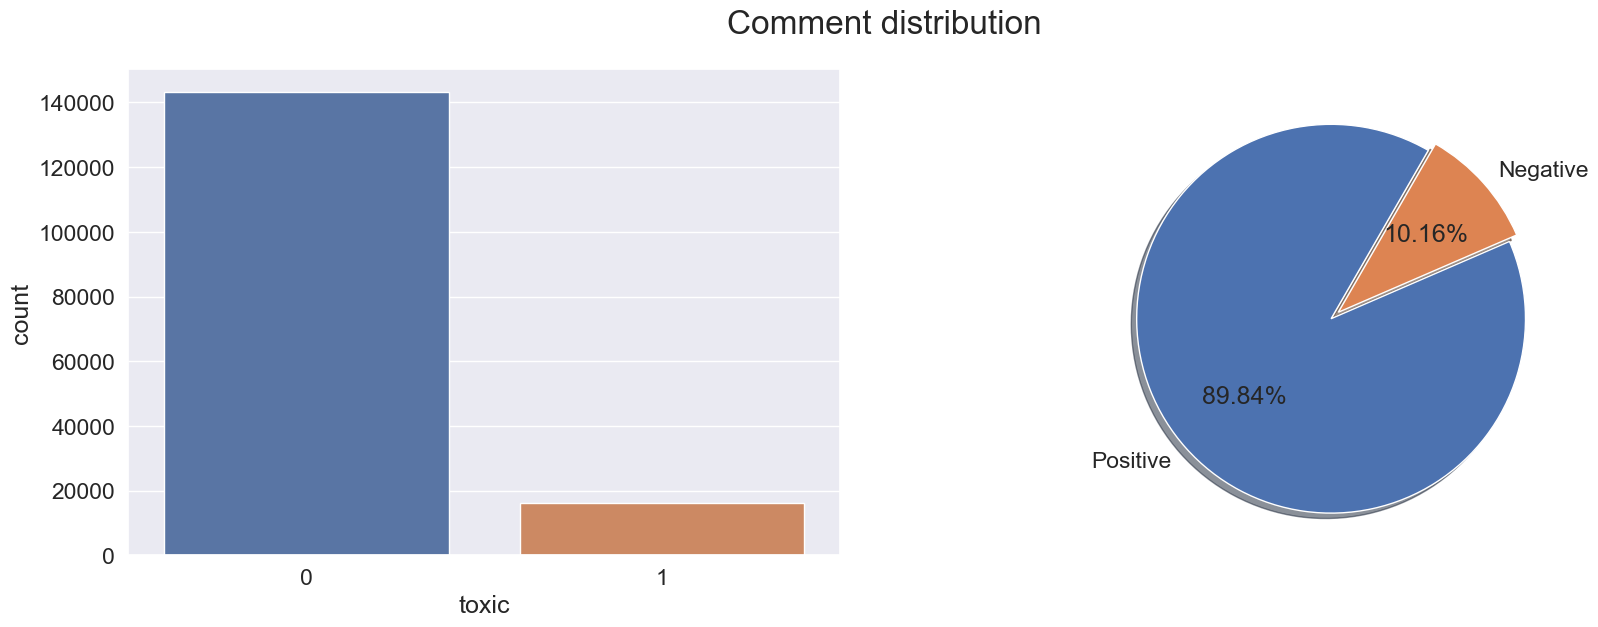

In [6]:
# Displaying the target feature

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(data=df_comments, ax=axes[0], x='toxic')
axes[1].pie(df_comments['toxic'].value_counts(),
            labels=['Positive', 'Negative'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Comment distribution', fontsize=24)
plt.show()

There is a class imbalance in the dataset: 90% positive comments and 10% toxic comments.

# Solving the Problem without BERT

Before moving on to word vector representation, I will preprocess the text. Firstly, I will tokenize each comment, lemmatize the words, and clean the text by removing unnecessary symbols. I will write a corresponding function to perform these actions.

In [7]:
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    joined = ' '.join(tokens)
    regular = re.sub(r'[^a-zA-Z]', ' ', joined)
    final_text = ' '.join(regular.split())
    return final_text

Let's display the first line of the original text for comparison:

In [8]:
print("Original text:", df_comments['text'][0])

Original text: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


I will apply the function to the data:

In [9]:
from tqdm import tqdm
tqdm.pandas()
df_comments['text'] = df_comments['text'].progress_apply(lemmatize_text) 

100%|███████████████████████████████████████████████████████████| 159292/159292 [00:31<00:00, 5040.86it/s]


Let's display the first line of the transformed text:

In [10]:
print("Cleaned and lemmatized text:", df_comments['text'][0])

Cleaned and lemmatized text: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please do n t remove the template from the talk page since I m retired now


The data has been preprocessed successfully.

To enable algorithms to determine the topic and sentiment of the text, they need to be trained on a corpus. Therefore, I will save the corpus as a feature variable.

In [11]:
features_nltk = df_comments['text']

Next, I will split the dataset into training and testing sets. When splitting, I will use the stratify argument to maintain the initial class distribution in the new datasets (since we previously observed a class imbalance).

In [12]:
train_features_nltk, test_features_nltk, train_target_nltk, test_target_nltk = train_test_split(features_nltk, \
                                                        df_comments['toxic'], test_size=0.2, \
                                                        random_state=RANDOM_STATE, stratify=df_comments['toxic'])
print(f"Number of instances per class in the target feature for the training set: {np.bincount(train_target_nltk)}")
print(f"Number of instances per class in the target feature for the testing set: {np.bincount(test_target_nltk)}")

Number of instances per class in the target feature for the training set: [114484  12949]
Number of instances per class in the target feature for the testing set: [28622  3237]


We obtained two datasets with 80% and 20% of the original dataset, respectively, while preserving the initial class distribution - 90% of examples belong to class 0, and 10% belong to class 1.

The data is ready, and we can proceed to the model training stage.

## Model Training

For this classification task I will use the `LogisticRegression`, `RandomForestClassifier` and `CatBoostClassifier` models. To account for the class imbalance, I will set the **`class_weight`** attribute for automatic class weight adjustment. I will use the `RandomizedSearchCV` class to search for optimal parameter values. I will employ a Pipeline, where the first step will include a vectorizer and text cleaning by removing stop words.

### LogisticRegression

In [13]:
pipeline_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])
parameters_logreg = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__max_iter': [10, 100, 1000]
}

grid_search_logreg = RandomizedSearchCV(pipeline_logreg, parameters_logreg, cv=3, n_jobs=-1, \
                                        scoring='f1', verbose=3)
grid_search_logreg.fit(train_features_nltk, train_target_nltk)

print(grid_search_logreg.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.689 total time= 1.7min
[CV 2/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1);, score=0.683 total time=   4.7s
[CV 2/3] END logreg__C=0.01, logreg__max_iter=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1);, score=0.683 total time=   5.1s
[CV 3/3] END logreg__C=0.1, logreg__max_iter=100, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2);, score=0.690 total time=  28.4s
[CV 3/3] END logreg__C=10, logreg__max_iter=100, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.779 total time=  52.5s
[CV 1/3] END logreg__C=10, logreg__max_iter=1000, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3);, score=0.771 total time= 1.8min
[CV 2/3] END logreg__C=10, logreg__max_iter=100, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.776 total time= 1.0min
[CV 3/3] END logreg__C=10, logreg__m

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### RandomForestClassifier

In [14]:
pipeline_forest = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('randomforest', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])
parameters_forest = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'randomforest__max_depth': [2, 8, 15],
    'randomforest__n_estimators': [10, 50, 100]
}

grid_search_forest = RandomizedSearchCV(pipeline_forest, parameters_forest, cv=3, n_jobs=-1, \
                                        scoring='f1', verbose=3)
grid_search_forest.fit(train_features_nltk, train_target_nltk)

print(grid_search_forest.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END logreg__C=0.01, logreg__max_iter=10, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.689 total time= 1.7min
[CV 2/3] END logreg__C=0.1, logreg__max_iter=1000, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.694 total time=  26.8s
[CV 3/3] END randomforest__max_depth=2, randomforest__n_estimators=10, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.226 total time=   3.8s
[CV 3/3] END randomforest__max_depth=8, randomforest__n_estimators=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1);, score=0.278 total time=   4.4s
[CV 3/3] END randomforest__max_depth=15, randomforest__n_estimators=50, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.372 total time=   6.0s
[CV 3/3] END randomforest__max_depth=8, randomforest__n_estimators=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.227 total time=  21.2s
[CV 1/3] END randomforest__max_depth=2, randomforest__n_estimators=10, tfidf__m

### CatBoostClassifier

For the CatBoostClassifier model I will create a `class_weights` dictionary with classes and corresponding weights calculated considering the class imbalance and pass it to the model as a parameter.

In [15]:
classes = np.unique(train_target_nltk)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target_nltk)
class_weights = dict(zip(classes, weights))

print(class_weights)

{0: 0.5565537542363999, 1: 4.9205730172214075}


In [16]:
pipeline_cbc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE, class_weights=class_weights))
])
parameters_cbc = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'catboost__learning_rate': [0.01, 0.1, 0.5],
    'catboost__depth': [3, 5, 7, 9],
    'catboost__iterations': [50, 100]
}

grid_search_cbc = RandomizedSearchCV(pipeline_cbc, parameters_cbc, cv=3, n_jobs=-1, \
                                        scoring='f1', verbose=3)
grid_search_cbc.fit(train_features_nltk, train_target_nltk)

print(grid_search_cbc.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3] END logreg__C=0.01, logreg__max_iter=10, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.689 total time= 1.6min
[CV 1/3] END logreg__C=0.1, logreg__max_iter=1000, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.696 total time=  24.4s
[CV 1/3] END randomforest__max_depth=2, randomforest__n_estimators=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.192 total time=  22.3s
[CV 3/3] END randomforest__max_depth=2, randomforest__n_estimators=100, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.290 total time=   4.9s
[CV 3/3] END randomforest__max_depth=15, randomforest__n_estimators=10, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.318 total time=   3.9s
0:	learn: 0.5575413	total: 1m 52s	remaining: 1h 31m 40s
1:	learn: 0.5102368	total: 3m 58s	remaining: 1h 35m 29s
2:	learn: 0.4837044	total: 6m 29s	remaining: 1h 41m 47s
3:	learn: 0.4657689	total: 9m 24s	remaining: 1h 48m 16s
4:	l

0:	learn: 0.5579493	total: 2m 36s	remaining: 2h 7m 24s
1:	learn: 0.5145688	total: 5m 33s	remaining: 2h 13m 32s
2:	learn: 0.4917090	total: 8m 23s	remaining: 2h 11m 21s
3:	learn: 0.4673087	total: 11m 17s	remaining: 2h 9m 46s
4:	learn: 0.4491988	total: 14m 9s	remaining: 2h 7m 26s
5:	learn: 0.4312694	total: 17m 1s	remaining: 2h 4m 54s
6:	learn: 0.4209549	total: 19m 57s	remaining: 2h 2m 37s
7:	learn: 0.4134981	total: 22m 47s	remaining: 1h 59m 39s
8:	learn: 0.4066468	total: 25m 39s	remaining: 1h 56m 52s
9:	learn: 0.4001013	total: 28m 32s	remaining: 1h 54m 11s
10:	learn: 0.3931524	total: 31m 17s	remaining: 1h 50m 58s
11:	learn: 0.3881414	total: 34m 6s	remaining: 1h 47m 59s
12:	learn: 0.3829217	total: 36m 59s	remaining: 1h 45m 16s
13:	learn: 0.3788602	total: 39m 22s	remaining: 1h 41m 14s
14:	learn: 0.3742796	total: 41m 37s	remaining: 1h 37m 7s
15:	learn: 0.3698052	total: 43m 49s	remaining: 1h 33m 7s
16:	learn: 0.3630824	total: 46m 5s	remaining: 1h 29m 29s
17:	learn: 0.3585894	total: 48m 25s	re

[CV 3/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.688 total time= 1.7min
[CV 3/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1);, score=0.683 total time=   4.6s
[CV 3/3] END logreg__C=0.01, logreg__max_iter=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1);, score=0.682 total time=   4.8s
[CV 2/3] END logreg__C=0.1, logreg__max_iter=100, tfidf__max_df=0.5, tfidf__ngram_range=(1, 2);, score=0.694 total time=  27.6s
[CV 2/3] END randomforest__max_depth=8, randomforest__n_estimators=100, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.306 total time=  33.8s
0:	learn: 0.6466087	total: 33.1s	remaining: 54m 32s
1:	learn: 0.6111054	total: 1m 8s	remaining: 55m 37s
2:	learn: 0.5837636	total: 1m 49s	remaining: 58m 52s
3:	learn: 0.5655204	total: 2m 32s	remaining: 1h 1m 1s
4:	learn: 0.5530284	total: 3m 16s	remaining: 1h 2m 20s
5:	learn: 0.5389773	total: 4m	remaining: 1h 2m 41s
6:	learn: 0.5

[CV 1/3] END randomforest__max_depth=15, randomforest__n_estimators=10, tfidf__max_df=0.5, tfidf__ngram_range=(1, 3);, score=0.239 total time=  27.3s
[CV 3/3] END randomforest__max_depth=2, randomforest__n_estimators=100, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.254 total time=  11.0s
0:	learn: 0.6443008	total: 42.3s	remaining: 1h 9m 50s
1:	learn: 0.6096911	total: 1m 25s	remaining: 1h 9m 42s
2:	learn: 0.5852478	total: 2m 6s	remaining: 1h 8m 9s
3:	learn: 0.5641355	total: 2m 53s	remaining: 1h 9m 27s
4:	learn: 0.5502977	total: 3m 41s	remaining: 1h 10m 16s
5:	learn: 0.5374577	total: 4m 27s	remaining: 1h 9m 58s
6:	learn: 0.5295004	total: 5m 12s	remaining: 1h 9m 17s
7:	learn: 0.5204480	total: 5m 57s	remaining: 1h 8m 31s
8:	learn: 0.5124095	total: 6m 41s	remaining: 1h 7m 37s
9:	learn: 0.5057358	total: 7m 34s	remaining: 1h 8m 10s
10:	learn: 0.4999191	total: 8m 35s	remaining: 1h 9m 31s
11:	learn: 0.4920956	total: 9m 32s	remaining: 1h 9m 59s
12:	learn: 0.4867487	total: 10m 31s	rem

[CV 1/3] END logreg__C=0.01, logreg__max_iter=10, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.697 total time= 1.4min
[CV 1/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1);, score=0.691 total time=   4.7s
[CV 2/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1);, score=0.683 total time=   4.6s
[CV 3/3] END logreg__C=0.01, logreg__max_iter=1000, tfidf__max_df=0.5, tfidf__ngram_range=(1, 1);, score=0.683 total time=   4.7s
[CV 3/3] END logreg__C=0.1, logreg__max_iter=1000, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2);, score=0.690 total time=  28.6s
[CV 2/3] END randomforest__max_depth=2, randomforest__n_estimators=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.197 total time=  21.5s
[CV 1/3] END randomforest__max_depth=2, randomforest__n_estimators=100, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.301 total time=   5.4s
[CV 2/3] END randomforest__max_depth=15, randomfor

37:	learn: 0.3190271	total: 38m 51s	remaining: 12m 16s
38:	learn: 0.3171052	total: 40m 10s	remaining: 11m 19s
39:	learn: 0.3152206	total: 40m 45s	remaining: 10m 11s
40:	learn: 0.3097515	total: 41m 57s	remaining: 9m 12s
41:	learn: 0.3081608	total: 42m 39s	remaining: 8m 7s
42:	learn: 0.3061815	total: 43m 23s	remaining: 7m 3s
43:	learn: 0.3043187	total: 44m 34s	remaining: 6m 4s
44:	learn: 0.3029797	total: 45m 11s	remaining: 5m 1s
45:	learn: 0.3005269	total: 46m 29s	remaining: 4m 2s
46:	learn: 0.2982499	total: 47m 9s	remaining: 3m
47:	learn: 0.2968230	total: 48m 15s	remaining: 2m
48:	learn: 0.2954815	total: 49m 1s	remaining: 1m
49:	learn: 0.2941970	total: 49m 27s	remaining: 0us
[CV 2/3] END catboost__depth=5, catboost__iterations=50, catboost__learning_rate=0.5, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.701 total time=79.0min
[CV 2/3] END logreg__C=10, logreg__max_iter=1000, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.769 total time= 2.9min
[CV 3/3] END randomfore

[CV 3/3] END logreg__C=10, logreg__max_iter=1000, tfidf__max_df=0.75, tfidf__ngram_range=(1, 3);, score=0.770 total time= 2.6min
[CV 2/3] END randomforest__max_depth=2, randomforest__n_estimators=10, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.224 total time=   3.8s
[CV 1/3] END randomforest__max_depth=8, randomforest__n_estimators=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 1);, score=0.275 total time=   4.5s
[CV 2/3] END randomforest__max_depth=15, randomforest__n_estimators=50, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.369 total time=   6.1s
[CV 2/3] END randomforest__max_depth=8, randomforest__n_estimators=10, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.227 total time=  22.7s
0:	learn: 0.6574319	total: 336ms	remaining: 33.2s
1:	learn: 0.6387580	total: 551ms	remaining: 27s
2:	learn: 0.6229126	total: 833ms	remaining: 26.9s
3:	learn: 0.6086890	total: 1.03s	remaining: 24.8s
4:	learn: 0.5998991	total: 1.23s	remaining: 23.4s
5:	learn: 0.5921916	to

89:	learn: 0.4278213	total: 1m 1s	remaining: 6.89s
90:	learn: 0.4271396	total: 1m 2s	remaining: 6.19s
91:	learn: 0.4264928	total: 1m 2s	remaining: 5.47s
92:	learn: 0.4258764	total: 1m 3s	remaining: 4.79s
93:	learn: 0.4251756	total: 1m 4s	remaining: 4.1s
94:	learn: 0.4244062	total: 1m 5s	remaining: 3.42s
95:	learn: 0.4233078	total: 1m 5s	remaining: 2.74s
96:	learn: 0.4225974	total: 1m 6s	remaining: 2.06s
97:	learn: 0.4212073	total: 1m 7s	remaining: 1.37s
98:	learn: 0.4206518	total: 1m 8s	remaining: 688ms
99:	learn: 0.4201117	total: 1m 8s	remaining: 0us
[CV 1/3] END catboost__depth=3, catboost__iterations=100, catboost__learning_rate=0.1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1);, score=0.699 total time= 1.9min
0:	learn: 0.6884723	total: 1.13s	remaining: 55.5s
1:	learn: 0.6839678	total: 1.98s	remaining: 47.5s
2:	learn: 0.6796991	total: 2.87s	remaining: 44.9s
3:	learn: 0.6755063	total: 3.64s	remaining: 41.8s
4:	learn: 0.6715346	total: 4.58s	remaining: 41.2s
5:	learn: 0.6675751	total:

0:	learn: 0.6468203	total: 2m 45s	remaining: 4h 32m 15s
1:	learn: 0.6140382	total: 5m 41s	remaining: 4h 39m 6s
2:	learn: 0.5918310	total: 8m 34s	remaining: 4h 37m 19s
3:	learn: 0.5739328	total: 11m 26s	remaining: 4h 34m 26s
4:	learn: 0.5599648	total: 14m 16s	remaining: 4h 31m 18s
5:	learn: 0.5504423	total: 17m 14s	remaining: 4h 30m 2s
6:	learn: 0.5433256	total: 20m 11s	remaining: 4h 28m 16s
7:	learn: 0.5356095	total: 23m 5s	remaining: 4h 25m 28s
8:	learn: 0.5274917	total: 26m 1s	remaining: 4h 23m 6s
9:	learn: 0.5201409	total: 28m 52s	remaining: 4h 19m 52s
10:	learn: 0.5145148	total: 31m 39s	remaining: 4h 16m 9s
11:	learn: 0.5085818	total: 34m 26s	remaining: 4h 12m 37s
12:	learn: 0.5023657	total: 36m 54s	remaining: 4h 6m 59s
13:	learn: 0.4955301	total: 39m 11s	remaining: 4h 43s
14:	learn: 0.4914475	total: 41m 16s	remaining: 3h 53m 55s
15:	learn: 0.4876109	total: 43m 27s	remaining: 3h 48m 6s
16:	learn: 0.4840161	total: 45m 44s	remaining: 3h 43m 19s
17:	learn: 0.4804861	total: 48m 3s	rema

50:	learn: 0.4683144	total: 12.9s	remaining: 12.4s
51:	learn: 0.4670604	total: 13.2s	remaining: 12.2s
52:	learn: 0.4654157	total: 13.4s	remaining: 11.9s
53:	learn: 0.4644796	total: 13.7s	remaining: 11.7s
54:	learn: 0.4625936	total: 13.9s	remaining: 11.4s
55:	learn: 0.4612659	total: 14.2s	remaining: 11.1s
56:	learn: 0.4601509	total: 14.5s	remaining: 10.9s
57:	learn: 0.4584871	total: 14.7s	remaining: 10.7s
58:	learn: 0.4565917	total: 14.9s	remaining: 10.4s
59:	learn: 0.4554376	total: 15.2s	remaining: 10.2s
60:	learn: 0.4544043	total: 15.5s	remaining: 9.92s
61:	learn: 0.4537323	total: 15.7s	remaining: 9.65s
62:	learn: 0.4528085	total: 16.1s	remaining: 9.47s
63:	learn: 0.4518779	total: 16.4s	remaining: 9.21s
64:	learn: 0.4507301	total: 16.7s	remaining: 8.97s
65:	learn: 0.4498720	total: 17s	remaining: 8.76s
66:	learn: 0.4484264	total: 17.3s	remaining: 8.53s
67:	learn: 0.4475953	total: 17.6s	remaining: 8.28s
68:	learn: 0.4466415	total: 18.1s	remaining: 8.13s
69:	learn: 0.4459527	total: 18.4s

49:	learn: 0.2555763	total: 2h 9m	remaining: 0us
[CV 3/3] END catboost__depth=9, catboost__iterations=50, catboost__learning_rate=0.5, tfidf__max_df=0.25, tfidf__ngram_range=(1, 3);, score=0.694 total time=160.2min
8:	learn: 0.5079397	total: 1m 38s	remaining: 16m 35s
9:	learn: 0.5002323	total: 1m 49s	remaining: 16m 23s
10:	learn: 0.4941563	total: 2m	remaining: 16m 12s
11:	learn: 0.4892502	total: 2m 10s	remaining: 16m
12:	learn: 0.4834425	total: 2m 21s	remaining: 15m 48s
13:	learn: 0.4788976	total: 2m 32s	remaining: 15m 37s
14:	learn: 0.4740265	total: 2m 43s	remaining: 15m 25s
15:	learn: 0.4684009	total: 2m 54s	remaining: 15m 14s
16:	learn: 0.4644111	total: 3m 5s	remaining: 15m 3s
17:	learn: 0.4601725	total: 3m 15s	remaining: 14m 51s
18:	learn: 0.4566983	total: 3m 26s	remaining: 14m 40s
19:	learn: 0.4520326	total: 3m 37s	remaining: 14m 28s
20:	learn: 0.4479000	total: 3m 48s	remaining: 14m 18s
21:	learn: 0.4440399	total: 3m 58s	remaining: 14m 6s
22:	learn: 0.4418144	total: 4m 9s	remainin

Let's summarize the results for three models we've built.

In [17]:
# Passing the feature values to the DataFrame constructor()

results = pd.DataFrame(
    {'Prediction Quality (F1 Score)' : [grid_search_logreg.best_score_, grid_search_forest.best_score_, grid_search_cbc.best_score_]})

# Setting column names to the indices

results.index = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']

# Displaying the table

display(results)

,Prediction Quality (F1 Score)
LogisticRegression,0.778224
RandomForestClassifier,0.373402
CatBoostClassifier,0.708596


Based on the results obtained, we can conclude that the best model for classifying comments as positive or negative is LogisticRegression (with an F1 score of 0.778, which meets the project's requirements).

## Model Testing

Evaluating the quality of the logistic regression model on the test set.

In [18]:
estimator = grid_search_logreg.best_estimator_

estimator.fit(train_features_nltk, train_target_nltk)
predicted_nltk = estimator.predict(test_features_nltk)

print('F1 score for logistic regression on the test set:', f1_score(test_target_nltk, predicted_nltk))

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 score for logistic regression on the test set: 0.7934436181514646


### BERT Solution

The data has already been cleaned and lemmatized in the previous stage. Before converting the texts into vectors, we need to prepare them. First, I will initialize the tokenizer.

In [19]:
tokenizer = transformers.BertTokenizer.from_pretrained("unitary/toxic-bert")

Let's see how the tokenizer works on the first row of the dataset.

In [20]:
# Displaying the original comment

print('Original: ', df_comments['text'][0])

# Displaying the tokenized version of the string

print('Tokenized: ', tokenizer.tokenize(df_comments['text'][0]))

# Displaying the sentence mapped to token IDs

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_comments['text'][0])))

Original:  Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please do n t remove the template from the talk page since I m retired now
Tokenized:  ['explanation', 'why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'hardcore', 'metallic', '##a', 'fan', 'were', 'reverted', 'they', 'were', 'n', 't', 'van', '##dal', '##isms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fa', '##c', 'and', 'please', 'do', 'n', 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'm', 'retired', 'now']
Token IDs:  [7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 2027, 2020, 1050, 1056, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1998, 3531, 2079, 1050, 1056, 6366, 1996, 23561, 201

To make the BERT model work, we need to convert the text into tokens. First, I will find the maximum token chain length for the majority of rows in our dataset. I will tokenize them and set 512 as the maximum length for the tokenizer because the model does not support longer chains.

In [21]:
max_len = 0
sentence_length = []

for text in df_comments['text']:
    tokenized = tokenizer.encode(text, max_length=512, truncation=True, add_special_tokens=True)
    max_len = max(max_len, len(tokenized))
    sentence_length.append(len(tokenized))

I will create a Series object and display its characteristics.

In [22]:
sentence_length = pd.Series(sentence_length)
sentence_length.describe()

count    159292.000000
mean         73.905350
std          91.790195
min           2.000000
25%          21.000000
50%          42.000000
75%          86.000000
max         512.000000
dtype: float64

To make the model train faster, I will set the actual maximum length of the token chain within the 75% quantile to 86 for the tokenizer.

In [23]:
max_len = 86

I will consider this maximum size of the remaining token sequences, tokenize each cleaned text value, and apply padding and truncation methods to ensure that the token sequence in each case has a fixed length, both for token sequences shorter than the maximum allowed value and for those that are longer. I will also add special tokens to mark the beginning and end of sentences (`[CLS]`, `[PAD]`, and `[SEP]`).

Let's check how these actions work on the first row of the dataset if I fix the tensor length at 100 (for a shorter and more illustrative form).

In [24]:
print('Returning the result as token indices and masks:',
      tokenizer(df_comments['text'][0], padding='max_length',
        max_length = 100, truncation=True, add_special_tokens=True,
          return_token_type_ids=False, return_attention_mask=True))

Returning the result as token indices and masks: {'input_ids': [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 2027, 2020, 1050, 1056, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1998, 3531, 2079, 1050, 1056, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 1045, 1049, 3394, 2085, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [25]:
input_ids = []
attention_masks = []

for text in df_comments['text']:
        encoded = tokenizer(text, padding='max_length', max_length = max_len,
                            truncation=True, add_special_tokens=True,
                            return_token_type_ids=False, return_attention_mask=True, return_tensors='pt')

        input_ids.append(encoded.get('input_ids'))
        attention_masks.append(encoded.get('attention_mask'))

In [26]:
print(input_ids[0])
print(attention_masks[0])

tensor([[  101,  7526,  2339,  1996, 10086,  2015,  2081,  2104,  2026,  5310,
         18442, 13076, 12392,  2050,  5470,  2020, 16407,  2027,  2020,  1050,
          1056,  3158,  9305, 22556,  2074,  8503,  2006,  2070,  3806,  2044,
          1045,  5444,  2012,  2047,  2259, 14421,  6904,  2278,  1998,  3531,
          2079,  1050,  1056,  6366,  1996, 23561,  2013,  1996,  2831,  3931,
          2144,  1045,  1049,  3394,  2085,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


I will initialize an instance of the BertModel class and pass it the pretrained model file.

In [30]:
model = transformers.BertModel.from_pretrained("unitary/toxic-bert")

Next, I will convert the texts into embeddings.

In [31]:
# Creating a helper class for token and mask representation

class CustomTextDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        comment_input_ids = self.input_ids[idx].flatten()
        comment_attention_mask = self.attention_masks[idx].flatten()
        return { "comment": comment_input_ids, "mask": comment_attention_mask }

# Preparing the dataframe

vectors_df = pd.DataFrame({ 'comment': input_ids, 'mask': attention_masks })

# Creating the dataset

TD = CustomTextDataset(vectors_df['comment'], vectors_df['mask'])

# Checking the first iteration on the dataset

print('First iteration of data set: ', next(iter(TD)), '\n')

# Displaying the dataset size

print('Length of data set: ', len(TD), '\n')

First iteration of data set:  {'comment': tensor([  101,  7526,  2339,  1996, 10086,  2015,  2081,  2104,  2026,  5310,
        18442, 13076, 12392,  2050,  5470,  2020, 16407,  2027,  2020,  1050,
         1056,  3158,  9305, 22556,  2074,  8503,  2006,  2070,  3806,  2044,
         1045,  5444,  2012,  2047,  2259, 14421,  6904,  2278,  1998,  3531,
         2079,  1050,  1056,  6366,  1996, 23561,  2013,  1996,  2831,  3931,
         2144,  1045,  1049,  3394,  2085,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
# Creating a data loader for our dataset

bert_recommended_batch_size = 64
DL_DS = DataLoader(TD, batch_size=bert_recommended_batch_size, shuffle=False)

# Creating an empty list to store the embeddings

embeddings = []

# Writing a loop over batches

for _i_batch, feed_data in enumerate(tqdm(DL_DS)):

        batch = feed_data["comment"]
        attention_mask_batch = feed_data["mask"]

        # Indicating that gradients are not needed
        
        with torch.no_grad():
            
            # Passing the data and mask to the model
            
            batch_embeddings = model(input_ids=batch, attention_mask=attention_mask_batch)

        # Converting the elements to numpy.array using the numpy() method
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())


  3%|█▉                                                                 | 73/2489 [01:25<47:14,  1.17s/it]


  6%|███▉                                                              | 147/2489 [02:53<45:29,  1.17s/it]


  9%|█████▊                                                            | 221/2489 [04:20<45:00,  1.19s/it]


 12%|███████▊                                                          | 295/2489 [05:46<42:46,  1.17s/it]


 15%|█████████▊                                                        | 369/2489 [07:12<41:16,  1.17s/it]


 18%|███████████▋                                                      | 443/2489 [08:39<39:36,  1.16s/it]


 21%|█████████████▋                                                    | 517/2489 [10:05<38:38,  1.18s/it]


 24%|███████████████▋                                                  | 591/2489 [11:32<38:02,  1.20s/it]


 27%|█████████████████▋                                                | 665/2489 [12:59<35:27,  1.17s/it]


 30%|███████████████████▌                                              | 739/2489 [14:25<34:12,  1.17s/it]


 33%|█████████████████████▌                                            | 813/2489 [15:53<32:48,  1.17s/it]


 36%|███████████████████████▌                                          | 887/2489 [17:20<31:07,  1.17s/it]


 39%|█████████████████████████▍                                        | 961/2489 [18:46<29:45,  1.17s/it]


 42%|███████████████████████████                                      | 1035/2489 [20:13<28:31,  1.18s/it]


 45%|████████████████████████████▉                                    | 1109/2489 [21:38<26:49,  1.17s/it]


 48%|██████████████████████████████▉                                  | 1183/2489 [23:05<25:11,  1.16s/it]


 51%|████████████████████████████████▊                                | 1257/2489 [24:30<23:43,  1.16s/it]


 53%|██████████████████████████████████▊                              | 1331/2489 [25:56<22:09,  1.15s/it]


 56%|████████████████████████████████████▋                            | 1405/2489 [27:21<20:17,  1.12s/it]


 59%|██████████████████████████████████████▌                          | 1479/2489 [28:45<18:58,  1.13s/it]


 62%|████████████████████████████████████████▌                        | 1553/2489 [30:09<17:37,  1.13s/it]


 65%|██████████████████████████████████████████▍                      | 1627/2489 [31:33<16:26,  1.14s/it]


 68%|████████████████████████████████████████████▍                    | 1701/2489 [32:57<14:51,  1.13s/it]


 71%|██████████████████████████████████████████████▎                  | 1775/2489 [34:21<13:27,  1.13s/it]


 74%|████████████████████████████████████████████████▎                | 1849/2489 [35:46<12:05,  1.13s/it]


 77%|██████████████████████████████████████████████████▏              | 1923/2489 [37:09<10:41,  1.13s/it]


 80%|████████████████████████████████████████████████████▏            | 1997/2489 [38:33<09:14,  1.13s/it]


 83%|██████████████████████████████████████████████████████           | 2071/2489 [39:57<07:54,  1.13s/it]


 86%|████████████████████████████████████████████████████████         | 2145/2489 [41:21<06:28,  1.13s/it]


 89%|█████████████████████████████████████████████████████████▉       | 2219/2489 [42:45<05:07,  1.14s/it]


 92%|███████████████████████████████████████████████████████████▉     | 2293/2489 [44:09<03:42,  1.14s/it]


 95%|█████████████████████████████████████████████████████████████▊   | 2367/2489 [45:34<02:18,  1.14s/it]


 98%|███████████████████████████████████████████████████████████████▋ | 2441/2489 [46:58<00:54,  1.15s/it]


100%|█████████████████████████████████████████████████████████████████| 2489/2489 [47:53<00:00,  1.15s/it]


I will collect all embeddings into a feature matrix.

In [33]:
features = np.concatenate(embeddings)
print(features[0])
print(len(features))

[-4.11893398e-01 -8.77829492e-01  7.77415931e-01 -4.82594937e-01
  8.50107074e-01  4.33518648e-01  1.98859274e-01  1.37468725e-01
 -3.45301300e-01 -3.45849425e-01  8.62327740e-02 -7.86473989e-01
  2.70417202e-02 -7.85285771e-01 -7.77828991e-01  4.87199008e-01
 -4.15122449e-01 -9.88148093e-01 -4.91547883e-01 -1.01553452e+00
  4.59231675e-01 -9.43391204e-01 -3.58602628e-02  1.05021626e-01
 -6.82014525e-01 -6.40863717e-01 -5.69600761e-01 -1.05171227e+00
 -4.59430784e-01  1.11508512e+00 -8.91744494e-01  7.88838267e-01
  4.22502518e-01  5.71764350e-01  5.17761469e-01  1.17000496e+00
  8.78636003e-01  3.07266861e-01  7.77286053e-01  7.87967563e-01
  8.27984512e-02 -7.13086486e-01  1.11169910e+00 -8.59033465e-01
 -1.11287482e-01  5.99534392e-01 -2.53653675e-01 -9.67781007e-01
 -1.56821966e+00 -1.01614678e+00  6.19224198e-02  9.11293924e-01
  5.87509573e-01  8.69534314e-01 -7.29906499e-01  7.61343837e-01
 -2.51698196e-01 -2.95845896e-01 -6.26520574e-01 -1.13482308e+00
 -9.84248042e-01 -5.68812

The features are ready, and we can proceed to the model training stage.

First, let's prepare the datasets.

In [34]:
train_features, test_features, train_target, test_target = train_test_split(features, \
                                                        df_comments['toxic'], test_size=0.2, \
                                                        random_state=RANDOM_STATE, stratify=df_comments['toxic'])
print(f"Number of instances per class in the target feature for the training set: {np.bincount(train_target)}")
print(f"Number of instances per class in the target feature for the testing set: {np.bincount(test_target)}")

Number of instances per class in the target feature for the training set: [114484  12949]
Number of instances per class in the target feature for the testing set: [28622  3237]


Next, I will train two models - LogisticRegression and RandomForestClassifier.

* **LogisticRegression**

In [35]:
model_logistic = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10, 100]
}

grid_logistic = GridSearchCV(model_logistic, param_grid_logistic, verbose=1, scoring='f1')
grid_logistic.fit(train_features, train_target)

print(grid_logistic.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.8668163065788359


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* **RandomForestClassifier**

In [36]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid_forest = {
    'max_depth': [2, 8, 15],
    'n_estimators': [10, 50, 100]
}

grid_forest = GridSearchCV(model_forest, param_grid_forest, verbose=1, scoring='f1')
grid_forest.fit(train_features, train_target)

print(grid_forest.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.9049093433614461


## General conclusion

Based on the results of our analysis, we have reached the following conclusions.

Solving the comment tone classification task **with BERT** showed better results than without BERT.

✔️ Performed tokenization, lemmatization, and text cleaning by removing unnecessary symbols and stop words.

✔️ Computed TF-IDF to determine sentiment.

✔️ Trained three models: LogisticRegression, RandomForestClassifier and CatBoostClassifier.

✔️ Conducted testing of the best model.

The best model for classifying comments as positive or negative without using BERT is LogisticRegression (with an F1 score of 0.778, meeting the project's requirements).

When using BERT, I preprocessed the data by cleaning it from unnecessary symbols and handling outliers. I trained the LogisticRegression and RandomForestClassifier models and obtained higher F1 scores compared to the first approach. The best overall result was achieved from RandomForestClassifier with BERT having a F1 score of 0.904.